In [16]:
import pandas as pd

df = pd.read_csv("../ALARM_DATA_DIR/PVCI-merged/All_Merged.csv")
df

,Event Time,Location Tag,Source,Condition,Action,Priority,Description,Value,Units
0,2025-01-01 00:00:00,SERVER_PVC,DAILY RP,PERIODIC,NaN,J 00,Report Periodic Request,12,NaN
1,2025-01-01 00:00:03,1600,PI1601,PVLOLO,NaN,J 00,HE1601 OUTLET,0.239591,kg/cm2G
2,2025-01-01 00:00:04,1500,TI1507,PVLOW,ACK,NaN,TW1501 BOTTOM,NaN,NaN
3,2025-01-01 00:00:05,IOLINK04_1,AIOR-704,OP Fail in circuit/field wire,OK,H 15,NaN,Channel_18_B,NaN
4,2025-01-01 00:00:07,1200,TIC1203,PVHIHI,NaN,H 00,HE1203 D/S TEMP,88.7875,C
...,...,...,...,...,...,...,...,...,...
903349,2025-03-17 10:55:00,1300,AI1301,PVLOW,NaN,L 00,VE1306 INLET,5.99933,ph
903350,2025-03-17 10:55:00,1300,AI1301,PVLOW,ACK,NaN,VE1306 INLET,NaN,NaN
903351,2025-03-17 10:55:00,SERVER_PVC,NaN,Demand,NaN,NaN,CSV export in progress...,NaN,NaN
903352,2025-03-17 10:56:00,SERVER_PVC,NaN,Demand,NaN,NaN,CSV export in progress...,NaN,NaN


# Logics


- An Alarm is in active state till no action perform on it and it is considered as 1 alarm till no action performing on it 
- If no one perform any action on an single source alarm for long duration then it will be considered as stale alarm
- And if an alarm from same source occurs repeatedly in short duration with the actions performed on it by operator as well
then it should be considered as Chattering

- with max alarm count in a flood a source could be considered as bad actor
- unhealthy source if an alarm occurs >= 10 in 10 minutes duration
- If multiple sources are in active state or multiple alarms occurs from multiple sources in 10 min window or more then it would be considered as Flood


In [54]:
# import pandas as pd

# # =====================================================
# # === KPI ENGINE FOR ALARM MANAGEMENT SYSTEM BACKEND ===
# # =====================================================

# def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
#     """Prepare and clean alarm event data"""
#     df = df.copy()
#     df['Event Time'] = pd.to_datetime(df['Event Time'], errors='coerce')
#     df['Action'] = df['Action'].astype(str).str.strip().replace({'nan': ''})
#     df = df.dropna(subset=['Event Time', 'Source'])
#     df = df.sort_values('Event Time')
#     df['Action'] = df['Action'].fillna('').str.upper().str.strip()
#     return df


# def get_alarm_cycles(df: pd.DataFrame) -> pd.DataFrame:
#     """Extract complete/incomplete alarm cycles for each source"""
#     alarm_cycles = []

#     for source, group in df.groupby('Source'):
#         group = group.sort_values('Event Time').reset_index(drop=True)
#         current_alarm = None

#         for _, row in group.iterrows():
#             action = row['Action']
#             time = row['Event Time']

#             if action == '' and current_alarm is None:
#                 current_alarm = {'source': source, 'start_time': time, 'ack_time': None, 'ok_time': None}

#             elif action == 'ACK' and current_alarm and current_alarm['ack_time'] is None:
#                 current_alarm['ack_time'] = time

#             elif action == 'OK' and current_alarm:
#                 current_alarm['ok_time'] = time
#                 alarm_cycles.append(current_alarm)
#                 current_alarm = None  # Reset after completion

#         # Handle unclosed alarm
#         if current_alarm:
#             alarm_cycles.append(current_alarm)

#     cycles_df = pd.DataFrame(alarm_cycles)
#     if not cycles_df.empty:
#         cycles_df['ack_delay'] = (cycles_df['ack_time'] - cycles_df['start_time']).dt.total_seconds() / 60
#         cycles_df['ok_delay'] = (cycles_df['ok_time'] - cycles_df['start_time']).dt.total_seconds() / 60
#     return cycles_df


# # =====================================================
# # ============== KPI CALCULATION FUNCTIONS ============
# # =====================================================

# def kpi_total_alarms(cycles_df: pd.DataFrame) -> int:
#     return len(cycles_df)


# def kpi_unique_sources(df: pd.DataFrame) -> int:
#     return df['Source'].nunique()


# def kpi_avg_ack_time(cycles_df: pd.DataFrame) -> float:
#     return round(cycles_df['ack_delay'].mean(), 2) if not cycles_df.empty else 0


# def kpi_avg_ok_time(cycles_df: pd.DataFrame) -> float:
#     return round(cycles_df['ok_delay'].mean(), 2) if not cycles_df.empty else 0


# def kpi_stale_alarms(cycles_df: pd.DataFrame, threshold_min: int = 30) -> int:
#     """Stale if no OK for > threshold"""
#     if cycles_df.empty:
#         return 0
#     stale = cycles_df[
#         (cycles_df['ok_time'].isna()) |
#         ((cycles_df['ok_time'] - cycles_df['start_time']).dt.total_seconds() / 60 > threshold_min)
#     ]
#     return len(stale)


# def kpi_chattering_alarms(cycles_df: pd.DataFrame, gap_min: int = 10) -> int:
#     """Count chattering alarms per source based on time gap between alarms"""
#     if cycles_df.empty:
#         return 0
#     chatter_count = 0
#     for source, group in cycles_df.groupby('source'):
#         group = group.sort_values('start_time').reset_index(drop=True)
#         group['gap'] = group['start_time'].diff().dt.total_seconds() / 60
#         chatter_count += group[group['gap'] < gap_min].shape[0]
#     return chatter_count


# # =====================================================
# # =============== MAIN KPI WRAPPER ====================
# # =====================================================

# def compute_all_kpis(df: pd.DataFrame) -> dict:
#     """Main wrapper to compute all KPIs efficiently"""
#     df = preprocess_data(df)
#     cycles_df = get_alarm_cycles(df)

#     total_alarms = kpi_total_alarms(cycles_df)
#     stale_alarms = kpi_stale_alarms(cycles_df)
#     chatter_alarms = kpi_chattering_alarms(cycles_df)

#     return {
#         "total_alarms": total_alarms,
#         "unique_sources": kpi_unique_sources(df),
#         "average_ack_time_min": kpi_avg_ack_time(cycles_df),
#         "average_ok_time_min": kpi_avg_ok_time(cycles_df),
#         "stale_alarms": stale_alarms,
#         "stale_alarm_percent": round((stale_alarms / total_alarms * 100), 2) if total_alarms else 0,
#         "chattering_alarms": chatter_alarms,
#         "chattering_alarm_percent": round((chatter_alarms / total_alarms * 100), 2) if total_alarms else 0
#     }


In [55]:
# kpis = compute_all_kpis(df)
# kpis

In [9]:
# alarm_kpi_service.py
import pandas as pd

# thresholds
STALE_THRESHOLD_MIN = 60
CHATTER_THRESHOLD_MIN = 10

# ---------- CORE KPI LOGIC  ----------
def count_unique_alarms(group):
    alarm_count = 0
    state = "IDLE"
    for _, row in group.iterrows():
        action = str(row["Action"]).upper().strip()
        if action == "":
            if state == "IDLE" or state == "ACKED":
                alarm_count += 1
                state = "ACTIVE"
        elif action == "ACK" and state == "ACTIVE":
            state = "ACKED"
        elif action == "OK":
            state = "IDLE"
    return alarm_count

# Updated Verison
def detect_stale_chatter(group):
    group = group.sort_values("Event Time")
    stale_flags = []
    chatter_flags = []

    last_alarm_time = None
    recent_alarms = []

    for i, row in group.iterrows():
        t = row["Event Time"]
        action = str(row["Action"]).upper().strip()

        # -------- STALE ALARM DETECTION --------
        if action == "" or action == "ALARM":
            # blank means new alarm
            if last_alarm_time is None:
                stale_flags.append(False)
            else:
                time_diff_min = (t - last_alarm_time).total_seconds() / 60
                stale_flags.append(time_diff_min > STALE_THRESHOLD_MIN)
            last_alarm_time = t
        else:
            stale_flags.append(False)

        # -------- CHATTERING DETECTION --------
        # keep alarms within last CHATTER_THRESHOLD_MIN minutes
        recent_alarms = [x for x in recent_alarms if (t - x).total_seconds() / 60 <= CHATTER_THRESHOLD_MIN]

        # add current time if it's a new alarm trigger (blank or ALARM)
        if action == "" or action == "ALARM":
            recent_alarms.append(t)

        # mark chattering if 3 or more alarms within window
        chatter_flags.append(len(recent_alarms) >= 3)

    group["is_stale"] = stale_flags
    group["is_chattering"] = chatter_flags
    return group




def get_alarm_cycles(df):
    cycles = []
    for src, g in df.groupby("Source"):
        g = g.sort_values("Event Time").reset_index(drop=True)
        cur = None
        for _, r in g.iterrows():
            a = str(r["Action"]).upper().strip()
            t = r["Event Time"]
            if a == "" and cur is None:
                cur = {"source": src, "start_time": t, "ack_time": None, "ok_time": None}
            elif a == "ACK" and cur and cur["ack_time"] is None:
                cur["ack_time"] = t
            elif a == "OK" and cur:
                cur["ok_time"] = t; cycles.append(cur); cur = None
        if cur: cycles.append(cur)
    dfc = pd.DataFrame(cycles)
    if not dfc.empty:
        dfc["ack_delay"] = (dfc["ack_time"] - dfc["start_time"]).dt.total_seconds() / 60
        dfc["ok_delay"] = (dfc["ok_time"] - dfc["start_time"]).dt.total_seconds() / 60
    return dfc


def calculate_alarm_kpis(df):
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"])
    df = df.sort_values(["Source", "Event Time"])

    """Prepare and clean alarm event data"""
    df = df.copy()
    df['Event Time'] = pd.to_datetime(df['Event Time'], errors='coerce')
    df['Action'] = df['Action'].astype(str).str.strip().replace({'nan': ''})
    # df = df.dropna(subset=['Event Time', 'Source'])
    # df = df.sort_values('Event Time')
    df = df.sort_values(["Source", "Event Time"])
    # df['Action'] = df['Action'].fillna('').str.upper().str.strip()

    unique = df.groupby("Source").apply(count_unique_alarms).reset_index(name="Unique_Alarms")
    analyzed = df.groupby("Source", group_keys=False).apply(detect_stale_chatter)
    stale = analyzed.groupby("Source")["is_stale"].sum().reset_index(name="Stale_Count")
    chat = analyzed.groupby("Source")["is_chattering"].sum().reset_index(name="Chattering_Count")

    cycles = get_alarm_cycles(df)
    if cycles.empty:
        avg_ack = avg_ok = completion = 0
    else:
        avg_ack = cycles["ack_delay"].mean()
        avg_ok = cycles["ok_delay"].mean()
        completion = cycles["ok_time"].notnull().mean() * 100

    df["Date"] = df["Event Time"].dt.date
    per_day = df.groupby("Date").size()
    hrs = (df["Event Time"].max() - df["Event Time"].min()).total_seconds() / 3600
    avg_day = per_day.mean()
    avg_hr = len(df) / hrs if hrs else 0
    avg_10m = avg_hr / 6
    overlimit_pct = (per_day > 288).mean() * 100

    summary = unique.merge(stale, on="Source", how="outer").merge(chat, on="Source", how="outer").fillna(0)
    kpis = dict(
        avg_ack_delay_min=avg_ack,
        avg_ok_delay_min=avg_ok,
        completion_rate_pct=completion,
        avg_alarms_per_day=avg_day,
        avg_alarms_per_hour=avg_hr,
        avg_alarms_per_10min=avg_10m,
        days_over_288_alarms_pct=overlimit_pct,
    )
    return summary, kpis, cycles


In [10]:
summary, kpis, cycles = calculate_alarm_kpis(df)

    # Prepare JSON-safe payloads
    
print("global_kpis", kpis)
print("per_source_summary", summary.to_dict(orient="records"))
print("alarm_cycles", cycles.to_dict(orient="records"))
    

C:\Users\hmaba\AppData\Local\Temp\ipykernel_16400\2358489898.py:103: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique = df.groupby("Source").apply(count_unique_alarms).reset_index(name="Unique_Alarms")
C:\Users\hmaba\AppData\Local\Temp\ipykernel_16400\2358489898.py:104: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = df.groupby("Source", group_keys=False).apply(detect_stale_chatter)


global_kpis {'avg_ack_delay_min': np.float64(140.80233469349903), 'avg_ok_delay_min': np.float64(185.6824968371187), 'completion_rate_pct': np.float64(98.88366627497062), 'avg_alarms_per_day': np.float64(12044.72), 'avg_alarms_per_hour': 498.833382417906, 'avg_alarms_per_10min': 83.13889706965101, 'days_over_288_alarms_pct': np.float64(100.0)}
per_source_summary [{'Source': '$ACTIVITY_330413F2352AB609', 'Unique_Alarms': 1, 'Stale_Count': 433, 'Chattering_Count': 51377}, {'Source': 'AAH10023', 'Unique_Alarms': 1, 'Stale_Count': 0, 'Chattering_Count': 0}, {'Source': 'AAH10026', 'Unique_Alarms': 2, 'Stale_Count': 0, 'Chattering_Count': 0}, {'Source': 'AAH10027', 'Unique_Alarms': 22, 'Stale_Count': 9, 'Chattering_Count': 17}, {'Source': 'AAH10028', 'Unique_Alarms': 1, 'Stale_Count': 0, 'Chattering_Count': 0}, {'Source': 'AERATION', 'Unique_Alarms': 1, 'Stale_Count': 15, 'Chattering_Count': 20}, {'Source': 'AERATION_CM', 'Unique_Alarms': 4, 'Stale_Count': 3, 'Chattering_Count': 0}, {'Source

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
kpis

{'avg_ack_delay_min': np.float64(140.80233469349903),
 'avg_ok_delay_min': np.float64(185.6824968371187),
 'completion_rate_pct': np.float64(98.88366627497062),
 'avg_alarms_per_day': np.float64(12044.72),
 'avg_alarms_per_hour': 498.833382417906,
 'avg_alarms_per_10min': 83.13889706965101,
 'days_over_288_alarms_pct': np.float64(100.0)}

In [12]:
summary

,Source,Unique_Alarms,Stale_Count,Chattering_Count
0,$ACTIVITY_330413F2352AB609,1,433,51377
1,AAH10023,1,0,0
2,AAH10026,2,0,0
3,AAH10027,22,9,17
4,AAH10028,1,0,0
...,...,...,...,...
1225,XSV8808,1,12,7
1226,XSV8811,1,0,0
1227,YI8800LP,6,5,0
1228,YI8802,21,8,0


In [13]:
cycles

,source,start_time,ack_time,ok_time,ack_delay,ok_delay
0,$ACTIVITY_330413F2352AB609,2025-01-01 01:59:46,NaT,NaT,NaN,NaN
1,AAH10023,2025-02-17 05:36:00,2025-02-17 05:37:00,2025-02-17 05:38:00,1.0,2.00
2,AAH10026,2025-03-05 07:12:00,2025-03-05 07:12:00,2025-03-05 07:12:00,0.0,0.00
3,AAH10026,2025-03-05 07:13:00,NaT,2025-03-05 07:13:00,NaN,0.00
4,AAH10027,2025-01-22 00:10:12,NaT,2025-01-22 00:10:15,NaN,0.05
...,...,...,...,...,...,...
83393,YI8841,2025-03-14 22:44:00,2025-03-14 22:45:00,2025-03-14 22:45:00,1.0,1.00
83394,YI8841,2025-03-14 22:46:00,NaT,2025-03-14 22:47:00,NaN,1.00
83395,YI8841,2025-03-14 22:49:00,NaT,2025-03-14 22:50:00,NaN,1.00
83396,YI8841,2025-03-14 22:55:00,NaT,2025-03-14 22:55:00,NaN,0.00


# Roungh Practices

In [12]:
df = df.copy()
df["Event Time"] = pd.to_datetime(df["Event Time"])
df = df.sort_values(["Source", "Event Time"])

"""Prepare and clean alarm event data"""
df = df.copy()
df['Event Time'] = pd.to_datetime(df['Event Time'], errors='coerce')
df['Action'] = df['Action'].astype(str).str.strip().replace({'nan': ''})
# df = df.dropna(subset=['Event Time', 'Source'])
# df = df.sort_values('Event Time')
df = df.sort_values(["Source", "Event Time"])
# df['Action'] = df['Action'].fillna('').str.upper().str.strip()



In [13]:
unique = df.groupby("Source").apply(count_unique_alarms).reset_index(name="Unique_Alarms")


C:\Users\hmaba\AppData\Local\Temp\ipykernel_22128\3220716368.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique = df.groupby("Source").apply(count_unique_alarms).reset_index(name="Unique_Alarms")


In [14]:
unique

,Source,Unique_Alarms
0,$ACTIVITY_330413F2352AB609,1
1,AAH10023,1
2,AAH10026,2
3,AAH10027,22
4,AAH10028,1
...,...,...
1225,XSV8808,1
1226,XSV8811,1
1227,YI8800LP,6
1228,YI8802,21


In [15]:
analyzed = df.groupby("Source", group_keys=False).apply(detect_stale_chatter)


C:\Users\hmaba\AppData\Local\Temp\ipykernel_22128\1519528932.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = df.groupby("Source", group_keys=False).apply(detect_stale_chatter)


In [16]:
analyzed

,Event Time,Location Tag,Source,Condition,Action,Priority,Description,Value,Units,is_stale,is_chattering
1441,2025-01-01 01:59:46,01,$ACTIVITY_330413F2352AB609,Command,,J 00,RCM;$330013f2cdc9e162-0006,Start,NaN,False,False
1524,2025-01-01 01:59:47,01,$ACTIVITY_330413F2352AB609,Formula,,J 00,DATA;$330013f2cdc9e162-0006,NaN,NaN,False,False
1523,2025-01-01 01:59:47,01,$ACTIVITY_330413F2352AB609,Formula,,J 00,DATA;$330013f2cdc9e162-0006,NaN,PPM,False,False
1522,2025-01-01 01:59:47,01,$ACTIVITY_330413F2352AB609,Formula,,J 00,DATA;$330013f2cdc9e162-0006,NaN,MIN,False,False
1521,2025-01-01 01:59:47,01,$ACTIVITY_330413F2352AB609,Formula,,J 00,DATA;$330013f2cdc9e162-0006,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
869728,2025-03-14 22:55:00,8800,YI8841,OFFNRM,,L 00,PURGE DEMAND,PURGE,NaN,False,False
869731,2025-03-14 22:55:00,8800,YI8841,OFFNRM,OK,L 00,PURGE DEMAND,NORMAL,NaN,False,True
869750,2025-03-14 22:56:00,8800,YI8841,OFFNRM,,L 00,PURGE DEMAND,PURGE,NaN,False,False
869755,2025-03-14 22:57:00,8800,YI8841,OFFNRM,OK,L 00,PURGE DEMAND,NORMAL,NaN,False,False


In [17]:
stale = analyzed.groupby("Source")["is_stale"].sum().reset_index(name="Stale_Count")

In [18]:
chat = analyzed.groupby("Source")["is_chattering"].sum().reset_index(name="Chattering_Count")

cycles = get_alarm_cycles(df)

In [21]:
if cycles.empty:
        avg_ack = avg_ok = completion = 0
else:
    avg_ack = cycles["ack_delay"].mean()
    avg_ok = cycles["ok_delay"].mean()
    completion = cycles["ok_time"].notnull().mean() * 100

df["Date"] = df["Event Time"].dt.date
per_day = df.groupby("Date").size()
hrs = (df["Event Time"].max() - df["Event Time"].min()).total_seconds() / 3600
avg_day = per_day.mean()
avg_hr = len(df) / hrs if hrs else 0
avg_10m = avg_hr / 6
overlimit_pct = (per_day > 288).mean() * 100

summary = unique.merge(stale, on="Source", how="outer").merge(chat, on="Source", how="outer").fillna(0)
kpis = dict(
    avg_ack_delay_min=avg_ack,
    avg_ok_delay_min=avg_ok,
    completion_rate_pct=completion,
    avg_alarms_per_day=avg_day,
    avg_alarms_per_hour=avg_hr,
    avg_alarms_per_10min=avg_10m,
    days_over_288_alarms_pct=overlimit_pct,
)

In [22]:
summary

,Source,Unique_Alarms,Stale_Count,Chattering_Count
0,$ACTIVITY_330413F2352AB609,1,0,44375
1,AAH10023,1,0,0
2,AAH10026,2,0,0
3,AAH10027,22,0,2
4,AAH10028,1,0,0
...,...,...,...,...
1225,XSV8808,1,0,0
1226,XSV8811,1,0,0
1227,YI8800LP,6,0,0
1228,YI8802,21,0,0


In [23]:
kpis

{'avg_ack_delay_min': np.float64(140.80233469349903),
 'avg_ok_delay_min': np.float64(185.6824968371187),
 'completion_rate_pct': np.float64(98.88366627497062),
 'avg_alarms_per_day': np.float64(12044.72),
 'avg_alarms_per_hour': 498.833382417906,
 'avg_alarms_per_10min': 83.13889706965101,
 'days_over_288_alarms_pct': np.float64(100.0)}

In [24]:
cycles

,source,start_time,ack_time,ok_time,ack_delay,ok_delay
0,$ACTIVITY_330413F2352AB609,2025-01-01 01:59:46,NaT,NaT,NaN,NaN
1,AAH10023,2025-02-17 05:36:00,2025-02-17 05:37:00,2025-02-17 05:38:00,1.0,2.00
2,AAH10026,2025-03-05 07:12:00,2025-03-05 07:12:00,2025-03-05 07:12:00,0.0,0.00
3,AAH10026,2025-03-05 07:13:00,NaT,2025-03-05 07:13:00,NaN,0.00
4,AAH10027,2025-01-22 00:10:12,NaT,2025-01-22 00:10:15,NaN,0.05
...,...,...,...,...,...,...
83393,YI8841,2025-03-14 22:44:00,2025-03-14 22:45:00,2025-03-14 22:45:00,1.0,1.00
83394,YI8841,2025-03-14 22:46:00,NaT,2025-03-14 22:47:00,NaN,1.00
83395,YI8841,2025-03-14 22:49:00,NaT,2025-03-14 22:50:00,NaN,1.00
83396,YI8841,2025-03-14 22:55:00,NaT,2025-03-14 22:55:00,NaN,0.00


In [14]:
from datetime import timedelta

def detect_stale_chatter(group):
    group = group.sort_values("Event Time").reset_index(drop=True)
    stale_count = 0
    chatter_count = 0
    
    # Track alarm start and state
    current_alarm_start = None
    last_action_time = None
    recent_alarms = []  # store timestamps of recent alarms
    
    for i, row in group.iterrows():
        t = row["Event Time"]
        action = str(row["Action"]).upper().strip()
        
        # ---- Handle alarm start ----
        if action == "" or action == "ALARM":
            # mark alarm start
            if current_alarm_start is None:
                current_alarm_start = t
            
            # ---- Chattering logic ----
            # keep only alarms within 10 minutes
            recent_alarms = [x for x in recent_alarms if (t - x).total_seconds() / 60 <= CHATTER_THRESHOLD_MIN]
            recent_alarms.append(t)
            
            # if 3 or more alarms in window -> count as chatter once
            if len(recent_alarms) == 3:
                chatter_count += 1
        
        # ---- Handle operator actions ----
        elif action in ["ACK", "OK"]:
            last_action_time = t
            # Check stale condition (long delay from alarm start)
            if current_alarm_start is not None:
                delay_min = (t - current_alarm_start).total_seconds() / 60
                if delay_min > STALE_THRESHOLD_MIN:
                    stale_count += 1
            current_alarm_start = None  # reset alarm after action

    # handle any unacknowledged long alarm still active
    if current_alarm_start and (group["Event Time"].iloc[-1] - current_alarm_start).total_seconds() / 60 > STALE_THRESHOLD_MIN:
        stale_count += 1

    # return one summarized row per source
    return pd.Series({
        "Stale_Count": stale_count,
        "Chattering_Count": chatter_count
    })


In [16]:
df = df.copy()
df["Event Time"] = pd.to_datetime(df["Event Time"])
df = df.sort_values(["Source", "Event Time"])

"""Prepare and clean alarm event data"""
df = df.copy()
df['Event Time'] = pd.to_datetime(df['Event Time'], errors='coerce')
df['Action'] = df['Action'].astype(str).str.strip().replace({'nan': ''})
# df = df.dropna(subset=['Event Time', 'Source'])
# df = df.sort_values('Event Time')
df = df.sort_values(["Source", "Event Time"])
# df['Action'] = df['Action'].fillna('').str.upper().str.strip()

# unique = df.groupby("Source").apply(count_unique_alarms).reset_index(name="Unique_Alarms")
analyzed = df.groupby("Source", group_keys=False).apply(detect_stale_chatter)
# stale = analyzed.groupby("Source")["is_stale"].sum().reset_index(name="Stale_Count")
# chat = analyzed.groupby("Source")["is_chattering"].sum().reset_index(name="Chattering_Count")

C:\Users\hmaba\AppData\Local\Temp\ipykernel_16400\1004864790.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = df.groupby("Source", group_keys=False).apply(detect_stale_chatter)


In [17]:
analyzed

,Stale_Count,Chattering_Count
Source,,
$ACTIVITY_330413F2352AB609,1,884
AAH10023,0,0
AAH10026,0,0
AAH10027,0,4
AAH10028,0,0
...,...,...
XSV8808,1,5
XSV8811,0,0
YI8800LP,0,0


In [ ]:
stale = analyzed.groupby("Source")["is_stale"].sum().reset_index(name="Stale_Count")
    chat = analyzed.groupby("Source")["is_chattering"].sum().reset_index(name="Chattering_Count")

In [18]:
# alarm_classification_service.py
import pandas as pd

# Thresholds (adjustable)
STALE_THRESHOLD_MIN = 3600        # Minutes with no OK = stale
CHATTER_THRESHOLD_MIN = 10      # Minutes window for chattering
CHATTER_COUNT_THRESHOLD = 3     # Min activations in window

# ---------- CORE KPI LOGIC ----------

def count_unique_alarms(group):
    """Counts distinct alarm activations (Blank→ACK→OK)"""
    alarm_count = 0
    state = "IDLE"
    for _, row in group.iterrows():
        action = str(row["Action"]).upper().strip()
        if action == "":  # new alarm trigger
            if state in ["IDLE", "ACKED"]:
                alarm_count += 1
                state = "ACTIVE"
        elif action == "ACK" and state == "ACTIVE":
            state = "ACKED"
        elif action == "OK":
            state = "IDLE"
    return alarm_count


def detect_stale_and_chattering(group):
    """Detects stale and chattering alarms within each source"""
    group = group.sort_values("Event Time").reset_index(drop=True)
    stale_flags = []
    chatter_flags = []

    last_alarm_time = None
    recent_alarms = []

    for _, row in group.iterrows():
        t = row["Event Time"]
        action = str(row["Action"]).upper().strip()

        # --- Stale detection (no OK > 60 min) ---
        if action in ["", "ALARM"]:
            if last_alarm_time:
                diff = (t - last_alarm_time).total_seconds() / 60
                stale_flags.append(diff > STALE_THRESHOLD_MIN)
            else:
                stale_flags.append(False)
            last_alarm_time = t
        else:
            stale_flags.append(False)

        # --- Chattering detection (≥3 activations in 10 min) ---
        if action in [""]:
            recent_alarms = [x for x in recent_alarms if (t - x).total_seconds() / 60 <= CHATTER_THRESHOLD_MIN]
            recent_alarms.append(t)
            chatter_flags.append(len(recent_alarms) >= CHATTER_COUNT_THRESHOLD)
        else:
            chatter_flags.append(False)

    group["is_stale"] = stale_flags
    group["is_chattering"] = chatter_flags
    return group


def calculate_alarm_categories(df):
    """Main entry point to classify alarms per source"""
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df["Action"] = df["Action"].astype(str).str.strip().fillna("")

    # Sort & group by Source
    df = df.sort_values(["Source", "Event Time"])

    # Unique alarms per source
    unique_summary = df.groupby("Source").apply(count_unique_alarms).reset_index(name="Unique_Alarms")

    # Detect stale & chattering alarms
    analyzed = df.groupby("Source", group_keys=False).apply(detect_stale_and_chattering)
    stale_summary = analyzed.groupby("Source")["is_stale"].sum().reset_index(name="Stale_Count")
    chatter_summary = analyzed.groupby("Source")["is_chattering"].sum().reset_index(name="Chattering_Count")

    # Merge summaries
    summary = (
        unique_summary
        .merge(stale_summary, on="Source", how="outer")
        .merge(chatter_summary, on="Source", how="outer")
        .fillna(0)
    )

    # Standing = currently active (never got OK)
    standing = (
        df.groupby("Source")
        .apply(lambda g: int(((g["Action"].str.upper() != "OK").all())))
        .reset_index(name="Standing_Alarm")
    )

    # Repeating = same source triggered >1 times
    summary["Repeating_Alarm"] = (summary["Unique_Alarms"] > 1).astype(int)

    # Merge standing info
    final_summary = summary.merge(standing, on="Source", how="left")

    return final_summary


# ---------- Example Usage ----------
if __name__ == "__main__":
    # df = pd.read_csv("your_alarm_data.csv")  # Replace with your file
    result = calculate_alarm_categories(df)
    # print(result.head(10))


C:\Users\hmaba\AppData\Local\Temp\ipykernel_16400\490496175.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_summary = df.groupby("Source").apply(count_unique_alarms).reset_index(name="Unique_Alarms")
C:\Users\hmaba\AppData\Local\Temp\ipykernel_16400\490496175.py:78: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = df.groupby("Source", group_keys=False).apply(detect_stale_and_chattering)
C:\Users\h

In [19]:
result 

,Source,Unique_Alarms,Stale_Count,Chattering_Count,Repeating_Alarm,Standing_Alarm
0,$ACTIVITY_330413F2352AB609,1,433,51377,0,1
1,AAH10023,1,0,0,0,0
2,AAH10026,2,0,0,1,0
3,AAH10027,22,9,6,1,0
4,AAH10028,1,0,0,0,0
...,...,...,...,...,...,...
1225,XSV8808,1,12,7,0,1
1226,XSV8811,1,0,0,0,1
1227,YI8800LP,6,5,0,1,0
1228,YI8802,21,8,0,1,0


In [ ]:
# Unique Alarms -> OK

# Now we consider Stale = Standing 

# After that based on condition where condition = BAD, Fail that category is instrument fail 
# After that based on condition where condition = BAD, Fail that category is instrument fail 
# CHnage 
# Stale alarm if after threshold the action is blank then keep stale count same 
# Standing = 
# Chattering 

In [25]:
result['Repeating_Alarm'].max()

np.int64(1)

In [23]:
result['Chattering_Count'].sum()

np.int64(547948)

In [24]:
result['Unique_Alarms'].sum()

np.int64(97329)

# New Calculations

In [33]:
def count_unique_alarms(group):
    """
    Count distinct alarm activations per Source.
    Rules:
    - Blank → ACK → OK  = 1 alarm
    - Blank → ACK → Blank = 2 alarms
    - Blank → Blank → OK = 1 alarm
    - Blank → ACK → OK → Blank = 2 alarms
    - Blank → OK → Blank = 2 alarms
    - Continuous blanks = 1 alarm (still active)
    """
    alarm_count = 0
    state = "IDLE"  # Possible: IDLE, ACTIVE, ACKED

    for _, row in group.iterrows():
        action = str(row["Action"]).upper().strip()

        if action == "":  # New alarm trigger (Blank)
            if state in ["IDLE", "ACKED"]:
                alarm_count += 1
                state = "ACTIVE"

        elif action == "ACK" and state == "ACTIVE":
            state = "ACKED"

        elif action == "OK":
            state = "IDLE"

    return alarm_count




In [32]:
df = df.copy()
df["Event Time"] = pd.to_datetime(df["Event Time"])
df = df.sort_values(["Source", "Event Time"])

"""Prepare and clean alarm event data"""
df = df.copy()
df['Event Time'] = pd.to_datetime(df['Event Time'], errors='coerce')
df['Action'] = df['Action'].astype(str).str.strip().replace({'nan': ''})
# df = df.dropna(subset=['Event Time', 'Source'])
# df = df.sort_values('Event Time')
df = df.sort_values(["Source", "Event Time"])

In [34]:
unique_summary = (
    df.groupby("Source")
      .apply(count_unique_alarms)
      .reset_index(name="Unique_Alarms")
)


C:\Users\hmaba\AppData\Local\Temp\ipykernel_16400\2694522122.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(count_unique_alarms)


In [35]:
unique_summary

,Source,Unique_Alarms
0,$ACTIVITY_330413F2352AB609,1
1,AAH10023,1
2,AAH10026,2
3,AAH10027,22
4,AAH10028,1
...,...,...
1225,XSV8808,1
1226,XSV8811,1
1227,YI8800LP,6
1228,YI8802,21


In [44]:
def detect_standing_alarms(group, threshold_min=60):
    """
    Detect Standing Alarms (previously called stale alarms).
    
    Standing alarm = active alarm lasting > threshold (default 60 min)
    without ACK or OK during that period.
    Only counted once per active alarm instance.
    """
    group = group.sort_values("Event Time").reset_index(drop=True)
    standing_count = 0
    active_start = None
    state = "IDLE"
    standing_flag = False  # prevents double counting

    for _, row in group.iterrows():
        action = str(row["Action"]).upper().strip()
        t = row["Event Time"]

        # Alarm starts (blank)
        if action == "" and state == "IDLE":
            state = "ACTIVE"
            active_start = t
            standing_flag = False  # reset for new alarm

        # Alarm acknowledged (still active)
        elif action == "ACK" and state == "ACTIVE":
            pass  # don't change state — still active

        # Alarm cleared (OK)
        elif action == "OK" and state in ["ACTIVE", "ACKED"]:
            state = "IDLE"
            active_start = None
            standing_flag = False  # reset

        # Check if it’s been standing too long
        if state == "ACTIVE" and active_start and not standing_flag:
            duration_min = (t - active_start).total_seconds() / 60
            if duration_min >= threshold_min:
                standing_count += 1
                standing_flag = True  # mark counted, don't double count

    return standing_count


In [45]:
def detect_standing_alarm_categories(group, threshold_min=60):
    """
    Detect Standing Alarms and classify into:
      - Instrument Failure (Condition contains 'FAIL' or 'BAD')
      - Stale Alarm (long active alarm without these keywords)
    """
    group = group.sort_values("Event Time").reset_index(drop=True)

    standing_count = 0
    instrument_failure_count = 0
    stale_count = 0

    active_start = None
    active_condition = ""
    state = "IDLE"
    standing_flag = False  # prevent double counting

    for _, row in group.iterrows():
        action = str(row["Action"]).upper().strip()
        t = row["Event Time"]
        condition = str(row.get("Condition", "")).upper()

        # New alarm starts
        if action == "" and state == "IDLE":
            state = "ACTIVE"
            active_start = t
            active_condition = condition
            standing_flag = False

        # Alarm acknowledged (still active)
        elif action == "ACK" and state == "ACTIVE":
            pass

        # Alarm cleared (OK)
        elif action == "OK" and state in ["ACTIVE", "ACKED"]:
            state = "IDLE"
            active_start = None
            standing_flag = False
            active_condition = ""

        # Standing check
        if state == "ACTIVE" and active_start and not standing_flag:
            duration_min = (t - active_start).total_seconds() / 60
            if duration_min >= threshold_min:
                standing_count += 1
                standing_flag = True  # count only once per alarm

                # Classify sub-type
                if any(k in active_condition for k in ["FAIL", "BAD"]):
                    instrument_failure_count += 1
                else:
                    stale_count += 1

                # reset after marking standing
                state = "IDLE"
                active_start = None
                active_condition = ""

    return pd.Series({
        "Standing_Alarms": standing_count,
        "Instrument_Failure": instrument_failure_count,
        "Stale_Alarms": stale_count
    })


In [56]:
standing_summary = (
    df.groupby("Source")
      .apply(detect_standing_alarm_categories, threshold_min=3600)
      .reset_index()
)


C:\Users\hmaba\AppData\Local\Temp\ipykernel_16400\48266073.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_standing_alarm_categories, threshold_min=3600)


In [59]:
standing_summary["Instrument_Failure"].describe()

count    1230.000000
mean        0.009756
std         0.133437
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: Instrument_Failure, dtype: float64

In [38]:
standing_summary = (
    df.groupby("Source")
      .apply(detect_standing_alarms, threshold_min=60)
      .reset_index(name="Standing_Alarms")
)


C:\Users\hmaba\AppData\Local\Temp\ipykernel_16400\3353199647.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_standing_alarms, threshold_min=60)


In [39]:
standing_summary

,Source,Standing_Alarms
0,$ACTIVITY_330413F2352AB609,1
1,AAH10023,0
2,AAH10026,0
3,AAH10027,0
4,AAH10028,0
...,...,...
1225,XSV8808,1
1226,XSV8811,0
1227,YI8800LP,0
1228,YI8802,0


In [42]:
standing_summary["Standing_Alarms"].max()

np.int64(354)

In [60]:
def get_alarm_cycles_aligned(df):
    """
    Build alarm cycles aligned to the same state machine used by count_unique_alarms().
    Each returned row is one unique alarm cycle with start_time, ack_time (optional) and ok_time (optional).
    """
    cycles = []

    # ensure proper types & order
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df = df.sort_values(["Source", "Event Time"])

    for src, g in df.groupby("Source"):
        g = g.reset_index(drop=True)
        state = "IDLE"    # IDLE, ACTIVE, ACKED
        cur = None        # dict holding current cycle when started

        for _, r in g.iterrows():
            a = str(r["Action"]).upper().strip()
            t = r["Event Time"]

            # start a new alarm when Blank and state is IDLE or ACKED
            if a in ["", "ALARM"]:
                if state in ["IDLE", "ACKED"]:
                    # start new cycle
                    cur = {"source": src, "start_time": t, "ack_time": None, "ok_time": None}
                    state = "ACTIVE"
                else:
                    # state == ACTIVE -> continuation of same alarm, ignore
                    pass

            elif a == "ACK":
                if state == "ACTIVE" and cur is not None and cur["ack_time"] is None:
                    cur["ack_time"] = t
                    state = "ACKED"
                else:
                    # ACK without active alarm — ignore
                    pass

            elif a == "OK":
                # closing the current alarm (if any)
                if state in ["ACTIVE", "ACKED"] and cur is not None:
                    cur["ok_time"] = t
                    cycles.append(cur)
                    cur = None
                # reset state to IDLE after OK
                state = "IDLE"

            else:
                # other actions: ignore for state transitions
                pass

        # End of group: if there's an open cycle, keep it (incomplete)
        if cur is not None:
            cycles.append(cur)

    dfc = pd.DataFrame(cycles)
    if not dfc.empty:
        dfc["ack_delay"] = (dfc["ack_time"] - dfc["start_time"]).dt.total_seconds() / 60
        dfc["ok_delay"] = (dfc["ok_time"] - dfc["start_time"]).dt.total_seconds() / 60
    return dfc


In [61]:
# compute unique count (as before)
# unique = df.groupby("Source").apply(count_unique_alarms).reset_index(name="Unique_Alarms")

# compute cycles aligned with unique logic
cycles = get_alarm_cycles_aligned(df)



In [62]:
def detect_standing_and_instrument_failure_from_cycles(cycles_df, raw_df, threshold_min=60):
    """
    Detect Standing Alarms and classify them as:
      - Instrument Failure (Condition contains 'FAIL' or 'BAD')
      - Stale Alarm (long active alarm without these keywords)

    Args:
        cycles_df : DataFrame returned by get_alarm_cycles_aligned()
                    Columns: source, start_time, ack_time, ok_time
        raw_df    : Original dataframe containing 'Source', 'Event Time', 'Condition'
        threshold_min : Minutes to consider alarm as 'standing'
    Returns:
        pd.DataFrame with counts per Source:
          [Standing_Alarms, Instrument_Failure, Stale_Alarms]
    """

    if cycles_df.empty:
        return pd.DataFrame(columns=["Source", "Standing_Alarms", "Instrument_Failure", "Stale_Alarms"])

    raw_df = raw_df.copy()
    raw_df["Condition"] = raw_df["Condition"].astype(str).str.upper()
    raw_df["Event Time"] = pd.to_datetime(raw_df["Event Time"], errors="coerce")

    results = []

    for src, g in cycles_df.groupby("source"):
        standing_count = 0
        instrument_failure_count = 0
        stale_count = 0

        for _, r in g.iterrows():
            start = r["start_time"]
            ok_time = r["ok_time"]

            # duration calculation
            if pd.notnull(ok_time):
                duration_min = (ok_time - start).total_seconds() / 60
            else:
                # still active → use latest event time for duration
                last_event = raw_df.loc[raw_df["Source"] == src, "Event Time"].max()
                duration_min = (last_event - start).total_seconds() / 60 if pd.notnull(last_event) else 0

            # check if alarm has been standing for more than threshold
            if duration_min >= threshold_min:
                standing_count += 1

                # find the latest condition during this period
                cond_subset = raw_df[
                    (raw_df["Source"] == src)
                    & (raw_df["Event Time"] >= start)
                    & (raw_df["Event Time"] <= (ok_time if pd.notnull(ok_time) else raw_df["Event Time"].max()))
                ]

                # Combine all conditions seen in this alarm period
                all_conditions = " ".join(cond_subset["Condition"].dropna().astype(str))

                # classify
                if any(k in all_conditions for k in ["FAIL", "BAD"]):
                    instrument_failure_count += 1
                else:
                    stale_count += 1

        results.append({
            "Source": src,
            "Standing_Alarms": standing_count,
            "Instrument_Failure": instrument_failure_count,
            "Stale_Alarms": stale_count
        })

    return pd.DataFrame(results)


In [ ]:
# now any standing/chatter/unhealthy logic can safely use cycles
standing_summary = detect_standing_and_instrument_failure_from_cycles(cycles, df, threshold_min=60)


# Updated Calculation For Standing Alarms

In [4]:
import pandas as pd

# Threshold in minutes for a standing alarm to become stale
STALE_THRESHOLD_MIN = 3600

def analyze_basic_alarm_states(df):
    """
    ISO-style alarm state analysis
    Calculates:
      - Unique Alarms
      - Standing Alarms
      - Stale Alarms
      - Instrument Failures
    """
    # --- Clean and sort ---
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df["Action"] = df["Action"].fillna("").str.upper().str.strip()
    df["Condition"] = df["Condition"].fillna("").str.upper().str.strip()
    df = df.sort_values(["Source", "Event Time"])

    results = []

    for src, group in df.groupby("Source"):
        state = "IDLE"
        unique_count = 0
        standing_count = 0
        stale_count = 0
        instrument_failure_count = 0

        active_start = None
        active_condition = ""
        standing_flag = False  # becomes True when counted once

        for _, row in group.iterrows():
            action = row["Action"]
            t = row["Event Time"]
            cond = row["Condition"]

            # --- NEW ALARM ---
            if action == "" and state in ["IDLE", "ACKED"]:
                unique_count += 1
                state = "ACTIVE"
                active_start = t
                active_condition = cond
                standing_flag = False

            # --- ACK HANDLING ---
            elif action == "ACK" and state == "ACTIVE":
                state = "ACKED"

            # --- OK HANDLING ---
            elif action == "OK" and state in ["ACTIVE", "ACKED"]:
                state = "IDLE"
                active_start = None
                active_condition = ""
                standing_flag = False

            # --- STANDING ALARM CHECK ---
            if state == "ACTIVE" and active_start:
                duration_min = (t - active_start).total_seconds() / 60

                # Alarm becomes standing after threshold
                if duration_min >= STALE_THRESHOLD_MIN and not standing_flag:
                    standing_count += 1
                    standing_flag = True  # count only once

                    # Subtype classification
                    if any(k in active_condition for k in ["FAIL", "BAD"]):
                        instrument_failure_count += 1
                    else:
                        stale_count += 1

                # If duration keeps increasing, do NOT increment again
                # until cleared with OK (handled above)

        results.append({
            "Source": src,
            "Unique_Alarms": unique_count,
            "Standing_Alarms": standing_count,
            "Stale_Alarms": stale_count,
            "Instrument_Failure": instrument_failure_count
        })

    return pd.DataFrame(results)


In [5]:
standing_alarm_analyses = analyze_basic_alarm_states(df)

In [6]:
standing_alarm_analyses

,Source,Unique_Alarms,Standing_Alarms,Stale_Alarms,Instrument_Failure
0,$ACTIVITY_330413F2352AB609,1,1,1,0
1,AAH10023,1,0,0,0
2,AAH10026,2,0,0,0
3,AAH10027,22,0,0,0
4,AAH10028,1,0,0,0
...,...,...,...,...,...
1225,XSV8808,1,1,1,0
1226,XSV8811,1,0,0,0
1227,YI8800LP,6,0,0,0
1228,YI8802,21,0,0,0


In [59]:
standing_alarm_analyses["Instrument_Failure"].max()

np.int64(1)

In [60]:

max_row_data = standing_alarm_analyses.loc[standing_alarm_analyses["Instrument_Failure"].idxmax()]
print(max_row_data)

Source                MIC1506A
Unique_Alarms              112
Standing_Alarms              7
Stale_Alarms                 6
Instrument_Failure           1
Name: 676, dtype: object


In [61]:
standing_alarm_analyses["Unique_Alarms"].sum()

np.int64(97329)

# Updated Calculation For Chattering Alarms

In [7]:
import pandas as pd
from collections import deque

# thresholds
CHATTER_WINDOW_MIN = 10
CHATTER_MIN_COUNT = 3
INSTRUMENT_KEYWORDS = ["FAIL", "BAD"]

def detect_repeating_and_chattering(df):
    """
    Detect Repeating Alarms, Chattering Alarms, and Instrument Failures
    using the same verified unique alarm logic.
    """

    # --- Data Cleaning ---
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df["Action"] = df["Action"].fillna("").astype(str).str.upper().str.strip()
    df["Condition"] = df["Condition"].fillna("").astype(str).str.upper().str.strip()
    df = df.sort_values(["Source", "Event Time"])

    results = []

    # --- Per-Source Processing ---
    for src, group in df.groupby("Source"):
        state = "IDLE"  # IDLE, ACTIVE, ACKED
        alarm_times = []       # start times of alarms (Blank or ALARM)
        cond_texts = []        # conditions corresponding to each alarm

        for _, row in group.iterrows():
            action = row["Action"]
            t = row["Event Time"]
            cond = row["Condition"]

            # Follow the exact verified unique alarm logic
            if action == "":  # new alarm trigger
                if state in ["IDLE", "ACKED"]:
                    alarm_times.append(t)
                    cond_texts.append(cond)
                    state = "ACTIVE"

            elif action == "ACK" and state == "ACTIVE":
                state = "ACKED"

            elif action == "OK":
                state = "IDLE"

        unique_alarms = len(alarm_times)
        is_repeating = int(unique_alarms > 1)
        repeating_count = max(0, unique_alarms - 1)

        # --- Instrument Failures ---
        instrument_failures = sum(
            1 for c in cond_texts if any(k in (c or "").upper() for k in INSTRUMENT_KEYWORDS)
        )

        # --- Chattering Detection (≥3 alarms within 10 mins) ---
        dq = deque()
        chattering_count = 0

        for t in alarm_times:
            # Remove alarms outside 10-min window
            while dq and (t - dq[0]).total_seconds() / 60 > CHATTER_WINDOW_MIN:
                dq.popleft()
            dq.append(t)

            # Check if we reached chattering threshold
            if len(dq) == CHATTER_MIN_COUNT:
                chattering_count += 1  # Count first crossing
            elif len(dq) > CHATTER_MIN_COUNT:
                # Already in chatter state, do not double count until reset
                pass

        results.append({
            "Source": src,
            "Unique_Alarms": unique_alarms,
            "Repeating_Alarms": repeating_count,
            "Chattering_Alarms": chattering_count,
            "Instrument_Failures": instrument_failures
        })

    return pd.DataFrame(results)


In [8]:
chattering_alarm_analyses = detect_repeating_and_chattering(df)

In [9]:
chattering_alarm_analyses

,Source,Unique_Alarms,Repeating_Alarms,Chattering_Alarms,Instrument_Failures
0,$ACTIVITY_330413F2352AB609,1,0,0,0
1,AAH10023,1,0,0,0
2,AAH10026,2,1,0,0
3,AAH10027,22,21,4,0
4,AAH10028,1,0,0,0
...,...,...,...,...,...
1225,XSV8808,1,0,0,0
1226,XSV8811,1,0,0,0
1227,YI8800LP,6,5,0,0
1228,YI8802,21,20,0,0


In [42]:
chattering_alarm_analyses["Unique_Alarms"].sum()

np.int64(97329)

In [44]:
chattering_alarm_analyses["Instrument_Failures"].max()

np.int64(9620)

In [45]:

max_row_data = chattering_alarm_analyses.loc[chattering_alarm_analyses["Instrument_Failures"].idxmax()]
print(max_row_data)

Source                 CI8102
Unique_Alarms            9933
Repeating_Alarms         9932
Chattering_Alarms         163
Instrument_Failures      9620
Name: 150, dtype: object


# Updated Unhealthy and Flood Calculation & Bad Actors

In [14]:

import pandas as pd
from datetime import timedelta

UNHEALTHY_THRESHOLD = 10
WINDOW_MINUTES = 10
FLOOD_SOURCE_THRESHOLD = 2

def detect_unhealthy_and_flood(df):
    """
    Detects:
    - Unhealthy sources (>=10 activations in 10 minutes)
    - Alarm floods (>=2 unhealthy sources active in same overlapping window)
    - Per-source flood contributions (frequency)
    """

    # 1️⃣ Clean and prepare
    df = df.copy()
    df["Event Time"] = pd.to_datetime(df["Event Time"], errors="coerce")
    df["Action"] = df["Action"].fillna("").str.upper().str.strip()
    df = df.sort_values(["Source", "Event Time"])

    # 2️⃣ Extract unique activations
    activations = []
    for src, g in df.groupby("Source"):
        state = "IDLE"
        for _, r in g.iterrows():
            action = r["Action"]
            t = r["Event Time"]
            if action == "" and state in ["IDLE", "ACKED"]:
                activations.append({"Source": src, "StartTime": t})
                state = "ACTIVE"
            elif action == "ACK":
                state = "ACKED"
            elif action == "OK":
                state = "IDLE"

    activations_df = pd.DataFrame(activations)
    if activations_df.empty:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    activations_df = activations_df.sort_values("StartTime")

    # 3️⃣ Detect Unhealthy windows (>=10 activations in 10 mins)
    unhealthy_periods = []
    window = timedelta(minutes=WINDOW_MINUTES)

    for src, g in activations_df.groupby("Source"):
        times = g["StartTime"].sort_values().tolist()
        start = 0
        for end, t_end in enumerate(times):
            while times[start] < t_end - window:
                start += 1
            count = end - start + 1
            if count >= UNHEALTHY_THRESHOLD:
                unhealthy_periods.append({
                    "Source": src,
                    "Window_Start": times[start],
                    "Window_End": t_end,
                    "Count": count
                })

    unhealthy_df = pd.DataFrame(unhealthy_periods)
    if unhealthy_df.empty:
        return activations_df, pd.DataFrame(), pd.DataFrame()

    # 4️⃣ Merge same-source unhealthy periods
    merged_unhealthy = []
    for src, g in unhealthy_df.groupby("Source"):
        g = g.sort_values("Window_Start")
        s, e = None, None
        for _, row in g.iterrows():
            if s is None:
                s, e = row["Window_Start"], row["Window_End"]
            elif row["Window_Start"] <= e:
                e = max(e, row["Window_End"])
            else:
                merged_unhealthy.append({"Source": src, "Start": s, "End": e})
                s, e = row["Window_Start"], row["Window_End"]
        if s:
            merged_unhealthy.append({"Source": src, "Start": s, "End": e})

    merged_unhealthy_df = pd.DataFrame(merged_unhealthy)

    # 5️⃣ Detect Floods (≥2 unhealthy sources overlapping)
    flood_windows = []
    for _, row in merged_unhealthy_df.iterrows():
        src1, s1, e1 = row["Source"], row["Start"], row["End"]

        overlapping = merged_unhealthy_df[
            (merged_unhealthy_df["Start"] <= e1) &
            (merged_unhealthy_df["End"] >= s1)
        ]
        sources = set(overlapping["Source"])
        if len(sources) >= FLOOD_SOURCE_THRESHOLD:
            flood_windows.append({
                "Flood_Start": s1,
                "Flood_End": e1,
                "Sources_Involved": list(sources),
                "Source_Count": len(sources)
            })

    flood_df = pd.DataFrame(flood_windows).drop_duplicates(subset=["Flood_Start", "Flood_End"])

    # 6️⃣ Summarize Flood Contributions
    flood_summary = []
    for _, row in flood_df.iterrows():
        s, e = row["Flood_Start"], row["Flood_End"]
        involved = row["Sources_Involved"]
        acts = activations_df[
            (activations_df["StartTime"] >= s) &
            (activations_df["StartTime"] <= e) &
            (activations_df["Source"].isin(involved))
        ]
        counts = acts["Source"].value_counts().to_dict()
        flood_summary.append({
            "Flood_Start": s,
            "Flood_End": e,
            "Sources_Involved": counts,
            "Source_Count": len(counts)
        })

    flood_summary_df = pd.DataFrame(flood_summary)

    # 7️⃣ Unhealthy Summary
    unhealthy_summary = merged_unhealthy_df.groupby("Source").size().reset_index(name="Unhealthy_Periods")

    return activations_df, unhealthy_summary, flood_summary_df


In [15]:
activations_df, unhealthy_summary, flood_summary_df = detect_unhealthy_and_flood(df)

In [18]:
unhealthy_summary

,Source,Unhealthy_Periods
0,ALMMNG4,7
1,CE1501B1,1
2,CH2FDCHK_A_CM,1
3,CI8101,13
4,CI8102,53
5,DI1506A,1
6,EI1104,33
7,EI1301B,1
8,EI1501,1
9,EI1502,1


In [19]:
flood_summary_df

,Flood_Start,Flood_End,Sources_Involved,Source_Count
0,2025-01-04 13:39:24,2025-01-04 13:55:31,"{'CI8102': 127, 'LI1107': 42}",2
1,2025-01-04 14:06:01,2025-01-04 15:16:47,"{'CI8102': 371, 'PI1413': 35, 'LI1107': 8}",3
2,2025-01-17 16:49:21,2025-01-17 18:21:17,"{'CI8102': 432, 'LI1107': 16}",2
3,2025-02-13 10:22:00,2025-02-13 11:31:00,"{'CI8102': 431, 'FI8106': 24}",2
4,2025-02-14 10:33:00,2025-02-14 11:12:00,"{'CI8102': 470, 'EI1104': 13}",2
...,...,...,...,...
71,2025-03-05 17:52:00,2025-03-05 18:01:00,"{'PDI1523': 18, 'FT1514': 2, 'FI1514': 2, 'FI1...",4
72,2025-01-04 15:08:22,2025-01-04 15:13:43,"{'PI1413': 26, 'CI8102': 9, 'LI1107': 2}",3
73,2025-01-08 21:05:15,2025-01-08 21:13:53,"{'PI1601': 16, 'EI1502': 5}",2
74,2025-02-17 20:50:00,2025-02-17 21:03:00,"{'PI1601': 38, 'LI1107': 26, 'EVENT_SCM1A': 9}",3


In [20]:
def identify_bad_actors(flood_summary_df, top_n=10):
    """
    Identify 'Bad Actor' sources — those contributing the most alarms during floods.
    Input:
        flood_summary_df: DataFrame with columns:
            ['Flood_Start', 'Flood_End', 'Sources_Involved', 'Source_Count']
            where 'Sources_Involved' is a dict {source: frequency}
        top_n: number of top contributors to return
    Output:
        DataFrame with columns:
            ['Source', 'Total_Alarm_In_Floods', 'Flood_Involvement_Count']
    """
    from collections import defaultdict

    source_alarm_counts = defaultdict(int)
    flood_participation = defaultdict(int)

    for _, row in flood_summary_df.iterrows():
        sources_dict = row["Sources_Involved"]
        for src, count in sources_dict.items():
            source_alarm_counts[src] += count
            flood_participation[src] += 1

    data = []
    for src in source_alarm_counts:
        data.append({
            "Source": src,
            "Total_Alarm_In_Floods": source_alarm_counts[src],
            "Flood_Involvement_Count": flood_participation[src],
        })

    bad_actors_df = pd.DataFrame(data).sort_values(
        "Total_Alarm_In_Floods", ascending=False
    ).reset_index(drop=True)

    return bad_actors_df.head(top_n)


In [21]:
bad_actors_df = identify_bad_actors(flood_summary_df)

In [22]:
bad_actors_df

,Source,Total_Alarm_In_Floods,Flood_Involvement_Count
0,CI8102,3185,18
1,LI1107,1611,33
2,FI1514,1345,14
3,FI1514BM,1327,14
4,FT1514,1327,14
5,FI8106,685,12
6,EVENT_SCM1A,216,21
7,DI1506A,168,3
8,MIC1506A,168,3
9,MY1506A,168,3


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_dashboard_charts(chatter_repeat_df, standing_df, flood_summary_df, bad_actors_df):
    """
    Generates dashboard KPI charts and returns structured data (x/y for frontend).
    Handles variations in column names automatically.
    """

    charts_data = {}

    # =====================================================
    # 1️⃣ Top 10 Sources by Chattering Alarms
    # =====================================================
    if "Chattering_Alarms" in chatter_repeat_df.columns:
        top_chatter = chatter_repeat_df.nlargest(10, "Chattering_Alarms")[["Source", "Chattering_Alarms"]]
        charts_data["chattering"] = {
            "x": top_chatter["Source"].tolist(),
            "y": top_chatter["Chattering_Alarms"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(top_chatter["Source"], top_chatter["Chattering_Alarms"])
        plt.xticks(rotation=45, ha="right")
        plt.title("Top 10 Sources by Chattering Alarms")
        plt.xlabel("Source")
        plt.ylabel("Chattering Alarms")
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 2️⃣ Top 10 Sources by Repeating Alarms
    # =====================================================
    if "Repeating_Alarms" in chatter_repeat_df.columns:
        top_repeat = chatter_repeat_df.nlargest(10, "Repeating_Alarms")[["Source", "Repeating_Alarms"]]
        charts_data["repeating"] = {
            "x": top_repeat["Source"].tolist(),
            "y": top_repeat["Repeating_Alarms"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(top_repeat["Source"], top_repeat["Repeating_Alarms"], color="orange")
        plt.xticks(rotation=45, ha="right")
        plt.title("Top 10 Sources by Repeating Alarms")
        plt.xlabel("Source")
        plt.ylabel("Repeating Alarms")
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 3️⃣ Standing vs Stale Alarms Comparison
    # =====================================================
    if {"Standing_Alarms", "Stale_Alarms"}.issubset(standing_df.columns):
        stand_stale = standing_df.nlargest(10, "Standing_Alarms")
        charts_data["standing_stale"] = {
            "x": stand_stale["Source"].tolist(),
            "y1": stand_stale["Standing_Alarms"].tolist(),
            "y2": stand_stale["Stale_Alarms"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(stand_stale["Source"], stand_stale["Standing_Alarms"],
                label="Standing", color="green", alpha=0.7)
        plt.bar(stand_stale["Source"], stand_stale["Stale_Alarms"],
                bottom=stand_stale["Standing_Alarms"],
                label="Stale", color="red", alpha=0.7)
        plt.xticks(rotation=45, ha="right")
        plt.title("Top 10 Standing vs Stale Alarms")
        plt.xlabel("Source")
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 4️⃣ Flood Duration Distribution
    # =====================================================
    if {"Flood_Start", "Flood_End"}.issubset(flood_summary_df.columns):
        flood_summary_df["Duration_Min"] = (
            flood_summary_df["Flood_End"] - flood_summary_df["Flood_Start"]
        ).dt.total_seconds() / 60

        charts_data["flood_duration"] = {
            "x": flood_summary_df["Flood_Start"].astype(str).tolist(),
            "y": flood_summary_df["Duration_Min"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.plot(flood_summary_df["Flood_Start"], flood_summary_df["Duration_Min"],
                 marker="o", color="purple")
        plt.xticks(rotation=45, ha="right")
        plt.title("Flood Duration Trend Over Time")
        plt.xlabel("Flood Start Time")
        plt.ylabel("Duration (minutes)")
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 5️⃣ Flood Size (Number of Sources Involved)
    # =====================================================
    if "Source_Count" in flood_summary_df.columns:
        charts_data["flood_size"] = {
            "x": flood_summary_df["Flood_Start"].astype(str).tolist(),
            "y": flood_summary_df["Source_Count"].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(flood_summary_df["Flood_Start"].astype(str),
                flood_summary_df["Source_Count"], color="teal")
        plt.xticks(rotation=45, ha="right")
        plt.title("Number of Sources Involved per Flood")
        plt.xlabel("Flood Start Time")
        plt.ylabel("Sources Involved")
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 6️⃣ Top 10 Bad Actors (Flexible Column Detection)
    # =====================================================
    if not bad_actors_df.empty:
        # detect proper column name
        col_map = [c for c in bad_actors_df.columns if "ALARM" in c.upper() or "COUNT" in c.upper()]
        if col_map:
            value_col = col_map[0]  # choose first matching column
        else:
            value_col = bad_actors_df.columns[-1]  # fallback

        top_bad = bad_actors_df.nlargest(10, value_col)
        charts_data["bad_actors"] = {
            "x": top_bad["Source"].tolist(),
            "y": top_bad[value_col].tolist()
        }

        plt.figure(figsize=(10, 5))
        plt.bar(top_bad["Source"], top_bad[value_col], color="crimson")
        plt.xticks(rotation=45, ha="right")
        plt.title("Top 10 Bad Actors by Flood Alarm Count")
        plt.xlabel("Source")
        plt.ylabel(value_col.replace("_", " ").title())
        plt.tight_layout()
        plt.show()

    return charts_data


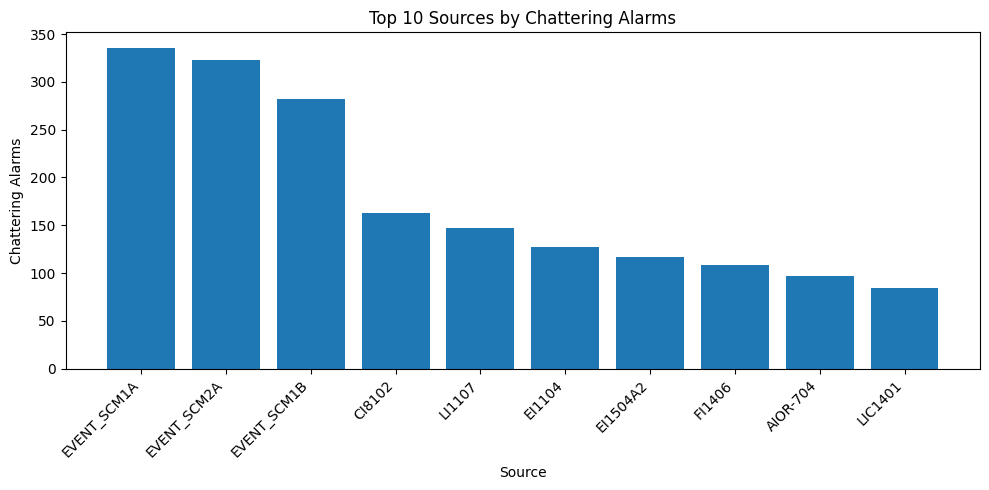

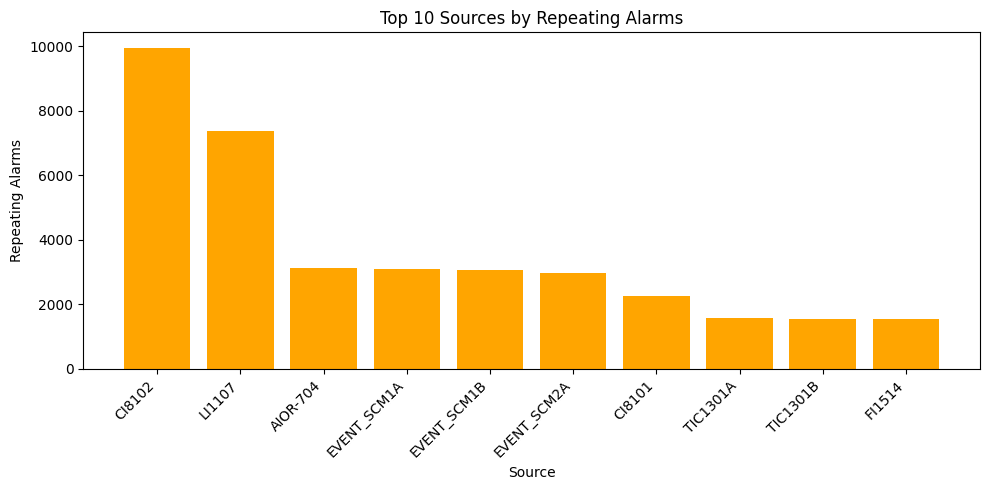

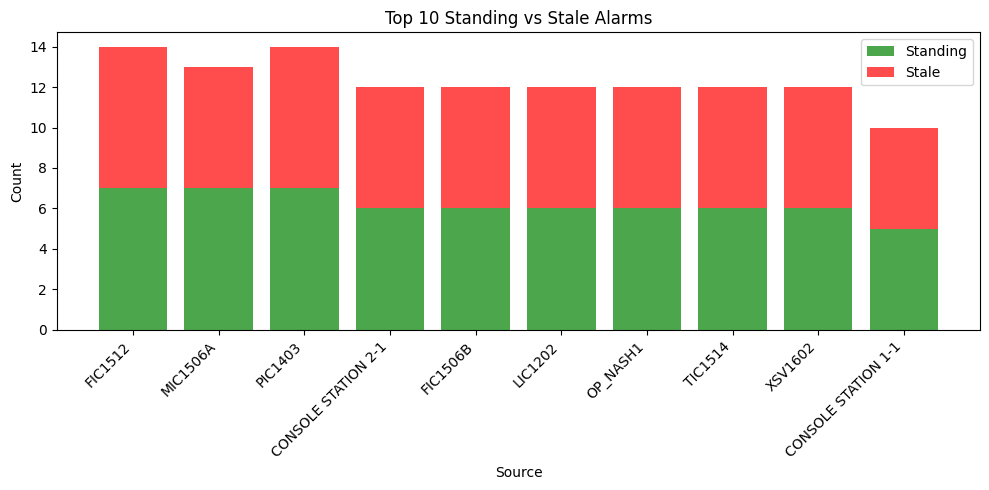

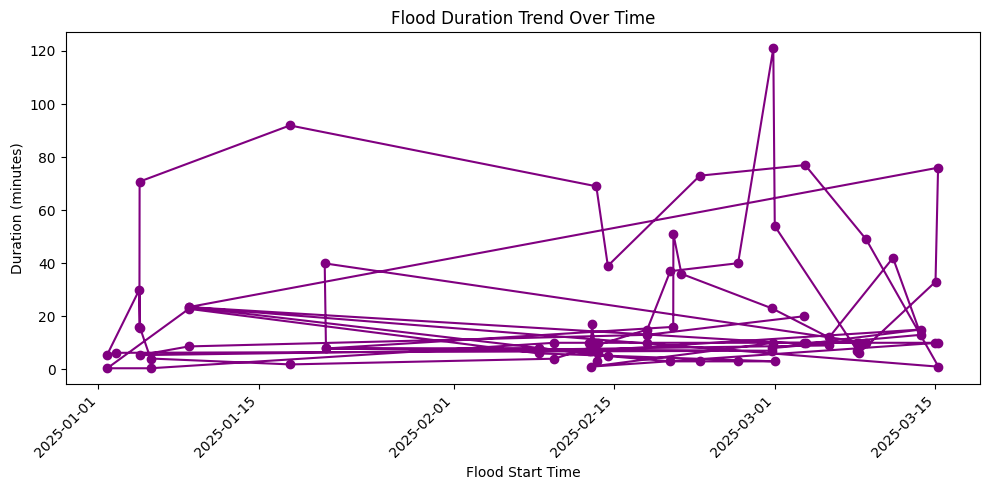

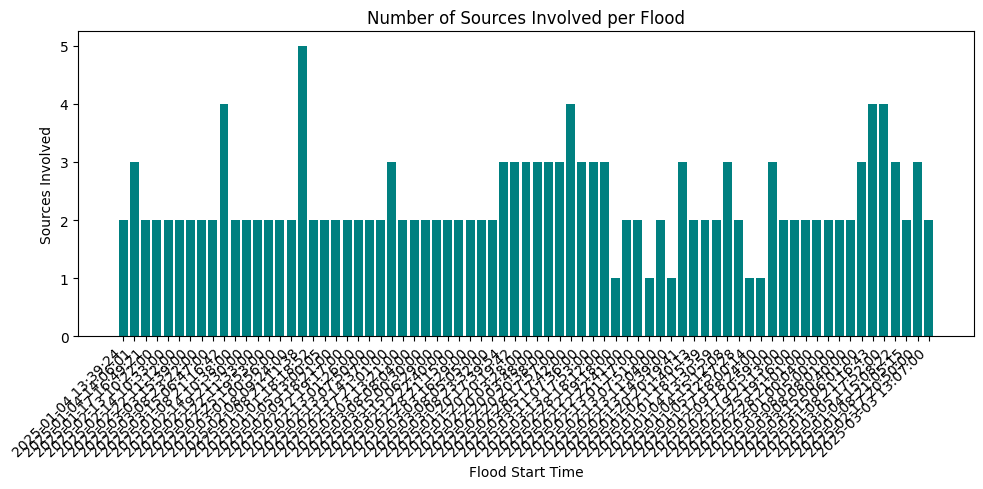

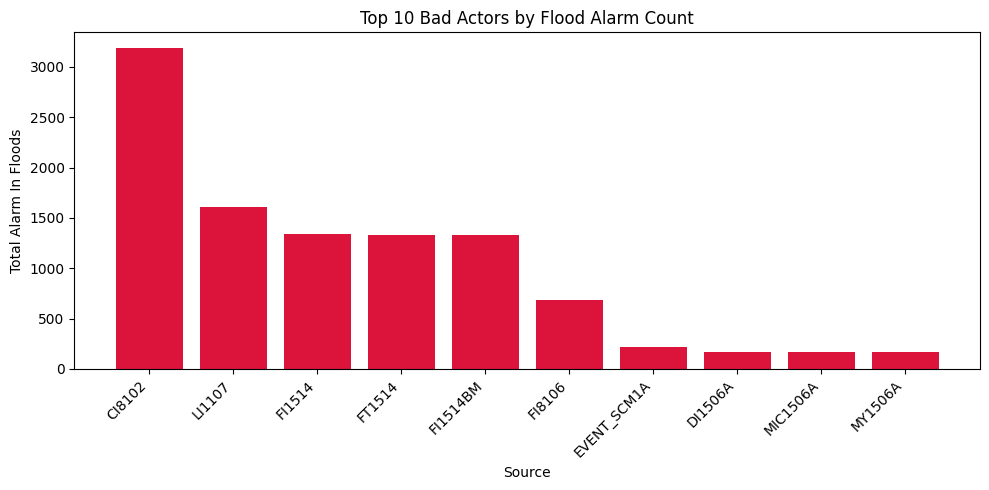

{'x': ['EVENT_SCM1A', 'EVENT_SCM2A', 'EVENT_SCM1B', 'CI8102', 'LI1107', 'EI1104', 'EI1504A2', 'FI1406', 'AIOR-704', 'LIC1401'], 'y': [335, 323, 282, 163, 147, 127, 117, 108, 97, 84]}


In [28]:
charts = generate_dashboard_charts(
    chattering_alarm_analyses,  # your chattering/repeating DataFrame
    standing_alarm_analyses,        # your standing/stale DataFrame
    flood_summary_df,   # your flood detection output
    bad_actors_df       # from identify_bad_actors()
)

# To inspect x/y data for frontend:
print(charts["chattering"])


# Charts for Chattering nd Stale

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_alarm_dashboard(stale_df, chattering_df):
    """
    Generate unified KPIs and chart-ready data from
    Stale/Standing and Repeating/Chattering DataFrames.
    """

    # --- 1️⃣ Merge both datasets ---
    combined = pd.merge(
        stale_df,
        chattering_df,
        on="Source",
        how="outer",
        suffixes=("_Standing", "_Chattering")
    ).fillna(0)

    # --- 2️⃣ Total KPIs ---
    total_alarms = int(combined["Unique_Alarms_Standing"].sum() + combined["Unique_Alarms_Chattering"].sum())
    total_standing = int(combined["Standing_Alarms"].sum())
    total_stale = int(combined["Stale_Alarms"].sum())
    total_repeating = int(combined["Repeating_Alarms"].sum())
    total_chattering = int(combined["Chattering_Alarms"].sum())
    total_instrument_failures = int(
        combined["Instrument_Failure"].sum() + combined["Instrument_Failures"].sum()
    )

    # --- 3️⃣ Prepare Chart Data ---

    # Pie chart: Alarm Distribution
    alarm_distribution = {
        "x": ["Standing", "Stale", "Repeating", "Chattering", "Instrument Failure"],
        "y": [total_standing, total_stale, total_repeating, total_chattering, total_instrument_failures]
    }

    # Top 10 sources by total alarms
    combined["Total_Alarms"] = (
        combined["Unique_Alarms_Standing"] + combined["Unique_Alarms_Chattering"]
    )
    top_sources = combined.nlargest(10, "Total_Alarms")[["Source", "Total_Alarms"]]
    top_sources_chart = {
        "x": top_sources["Source"].tolist(),
        "y": top_sources["Total_Alarms"].tolist()
    }

    # Stacked bar: Standing vs Chattering per top 10 sources
    top_stacked = combined.nlargest(10, "Total_Alarms")[["Source", "Standing_Alarms", "Chattering_Alarms"]]
    stacked_chart = {
        "x": top_stacked["Source"].tolist(),
        "Standing": top_stacked["Standing_Alarms"].tolist(),
        "Chattering": top_stacked["Chattering_Alarms"].tolist()
    }

    # --- 4️⃣ Summary KPIs dictionary ---
    kpi_summary = {
        "Total_Alarms": total_alarms,
        "Standing_Alarms": total_standing,
        "Stale_Alarms": total_stale,
        "Repeating_Alarms": total_repeating,
        "Chattering_Alarms": total_chattering,
        "Instrument_Failure": total_instrument_failures
    }

    # --- 5️⃣ Optional: Matplotlib Charts for validation ---
    plt.figure(figsize=(6, 6))
    plt.pie(alarm_distribution["y"], labels=alarm_distribution["x"], autopct="%1.1f%%")
    plt.title("Alarm Distribution Overview")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(top_sources_chart["x"], top_sources_chart["y"], color="skyblue")
    plt.title("Top 10 Alarm Sources")
    plt.xlabel("Source")
    plt.ylabel("Alarm Count")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(top_stacked["Source"], top_stacked["Standing_Alarms"], label="Standing")
    plt.bar(top_stacked["Source"], top_stacked["Chattering_Alarms"], bottom=top_stacked["Standing_Alarms"], label="Chattering")
    plt.title("Standing vs Chattering (Top 10 Sources)")
    plt.xlabel("Source")
    plt.ylabel("Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # --- 6️⃣ Return everything for frontend ---
    return {
        "alarm_distribution": alarm_distribution,
        "top_sources": top_sources_chart,
        "stacked_chart": stacked_chart,
        "kpi_summary": kpi_summary
    }


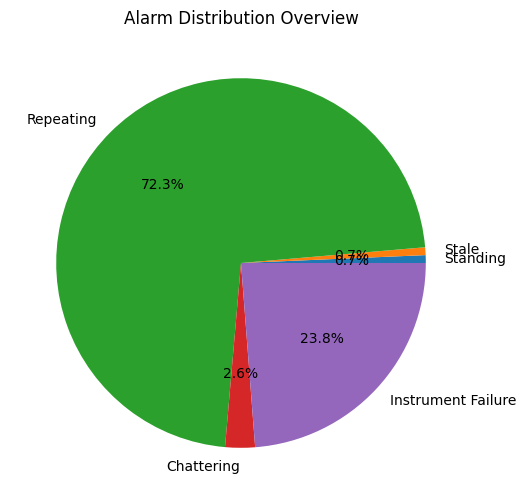

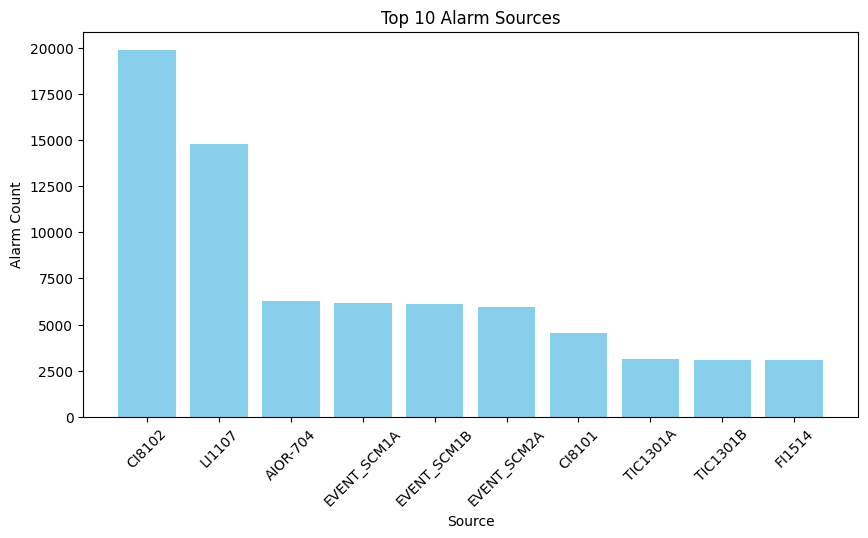

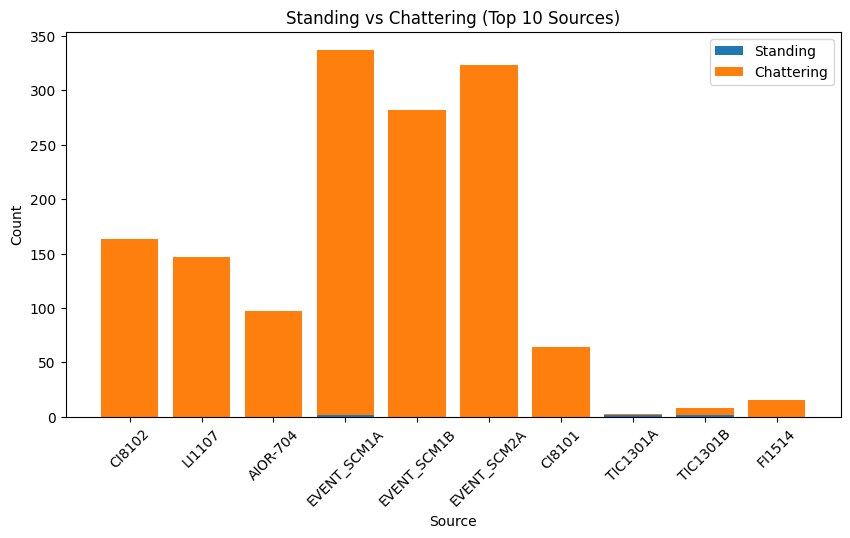

{'alarm_distribution': {'x': ['Standing',
   'Stale',
   'Repeating',
   'Chattering',
   'Instrument Failure'],
  'y': [904, 903, 96102, 3456, 31623]},
 'top_sources': {'x': ['CI8102',
   'LI1107',
   'AIOR-704',
   'EVENT_SCM1A',
   'EVENT_SCM1B',
   'EVENT_SCM2A',
   'CI8101',
   'TIC1301A',
   'TIC1301B',
   'FI1514'],
  'y': [19866, 14770, 6280, 6162, 6126, 5970, 4524, 3124, 3102, 3082]},
 'stacked_chart': {'x': ['CI8102',
   'LI1107',
   'AIOR-704',
   'EVENT_SCM1A',
   'EVENT_SCM1B',
   'EVENT_SCM2A',
   'CI8101',
   'TIC1301A',
   'TIC1301B',
   'FI1514'],
  'Standing': [0, 0, 0, 2, 0, 0, 0, 2, 2, 0],
  'Chattering': [163, 147, 97, 335, 282, 323, 64, 1, 6, 15]},
 'kpi_summary': {'Total_Alarms': 194658,
  'Standing_Alarms': 904,
  'Stale_Alarms': 903,
  'Repeating_Alarms': 96102,
  'Chattering_Alarms': 3456,
  'Instrument_Failure': 31623}}

In [71]:
generate_alarm_dashboard(standing_alarm_analyses, chattering_alarm_analyses)